# Transfer Learning - Fine Tuning

In [1]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [2]:
# Importing Daniel Bourke's helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

In [3]:
# Check how many images are in target folders
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Creating training and test dir paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
# Creating image dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
# Check train dataset
train_data_10percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
# Check class names
train_data_10percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# Getting sample batch data
for images, labels in train_data_10percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[4.80000000e+01 4.07704086e+01 3.54591827e+01]
   [3.51581612e+01 2.90918350e+01 2.89234676e+01]
   [3.50357170e+01 3.10357170e+01 3.16071434e+01]
   ...
   [1.67709213e+02 1.39352005e+02 1.05137741e+02]
   [1.69331635e+02 1.39331635e+02 1.05331627e+02]
   [1.69515259e+02 1.36515259e+02 1.03515259e+02]]

  [[6.27602043e+01 5.31887741e+01 4.65663261e+01]
   [4.62908134e+01 3.82908173e+01 3.64234695e+01]
   [4.10255165e+01 3.50561295e+01 3.70102081e+01]
   ...
   [1.65540771e+02 1.39770325e+02 1.04627487e+02]
   [1.67137772e+02 1.37137772e+02 1.03137764e+02]
   [1.70331665e+02 1.37331665e+02 1.04331665e+02]]

  [[6.91734695e+01 5.52500000e+01 4.43265305e+01]
   [7.03061218e+01 5.83061295e+01 5.33928642e+01]
   [8.86326599e+01 7.90816345e+01 7.98214340e+01]
   ...
   [1.65811157e+02 1.40239685e+02 1.05025429e+02]
   [1.65270416e+02 1.36270416e+02 1.02270416e+02]
   [1.67785721e+02 1.37785721e+02 1.03785713e+02]]

  ...

  [[2.08469604e+02 1.94112396e+02 1.96898132e+02]
   [2

## Creating Transfer Learning models with Keras' Functional API

### Model 0

In [9]:
# Creating baseline model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freezing the model to avoid changes to pre-trained patterns
base_model.trainable = False

# Creating inputs into the model
inputs = tf.keras.layers.Input(
    shape=(224, 224, 3),
    name="input_layer"
)

# If using ResNet50V2 (not EfficientNetB0), then input needs to be re-scaled
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# Passing the inputs to baseline model
x = base_model(inputs)
print(f"Shape after passing the inputs: {x.shape}.")

# Average pooling the outputs
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalPooling2D: {x.shape}.")

# Creating outputs of the model
outputs = tf.keras.layers.Dense(
    10,
    activation="softmax",
    name="output_layer"
)(x)

# Combining inputs and outputs to set a model
model_0 = tf.keras.Model(inputs, outputs)

Shape after passing the inputs: (None, 7, 7, 1280).
Shape after GlobalPooling2D: (None, 1280).


In [10]:
# Compiling the model
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
history_0 = model_0.fit(
    train_data_10percent,
    epochs=5,
    steps_per_epoch=len(train_data_10percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent")]
)

Saving TensorBoard log files to: transfer_learning/10_percent/20221218-190927
Epoch 1/5
24/24 [==============================] - 134s 5s/step - loss: 1.8797 - accuracy: 0.4120 - val_loss: 1.2996 - val_accuracy: 0.7171
Epoch 2/5
24/24 [==============================] - 102s 4s/step - loss: 1.1002 - accuracy: 0.7627 - val_loss: 0.8690 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 99s 4s/step - loss: 0.7976 - accuracy: 0.8213 - val_loss: 0.7474 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 99s 4s/step - loss: 0.6497 - accuracy: 0.8400 - val_loss: 0.6189 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 112s 5s/step - loss: 0.5543 - accuracy: 0.8627 - val_loss: 0.5603 - val_accuracy: 0.8668


In [11]:
# Evaluate against the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 188s 2s/step - loss: 0.5542 - accuracy: 0.8632


[0.5541886687278748, 0.8632000088691711]

In [12]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
# Getting summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
# Getting summary of the whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


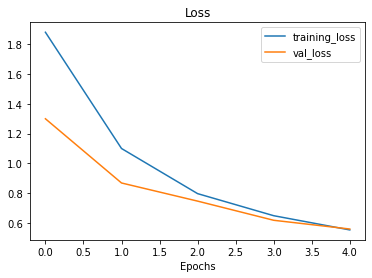

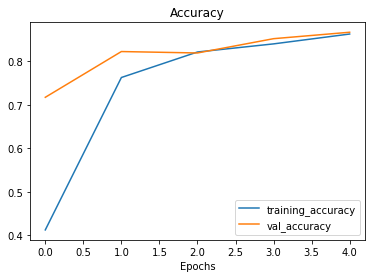

In [15]:
# Visualising the loss curves
plot_loss_curves(history_0)

### Underrstanfding Average Pooling 2D

In [16]:
# Defining input shape
input_shape =(1, 4, 4, 3) 

# Creating a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.26454744]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.891714  , -0.9384712 ]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728497,  0.40125778, -1.4145442 ],
         [-0.59318566, -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.2347968 , -0.56668764],
         [-0.35819843,  0.88698626,  0.5274477 ]]]], dtype=float32)>

In [17]:
# Passing our tensor through the Average Pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [18]:
# Replicating GlobalAveragePooling2D functionality
tf.reduce_mean(input_tensor=input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

### Model 1

In [19]:
# Creating training and test dirs
train_dir_1percent = "10_food_classes_1_percent/train/"
test_dir_1percent = "10_food_classes_1_percent/test/"

In [20]:
# Checking images
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [21]:
# Setting up data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE=32

train_data_1percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data_1percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
# Adding data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
    # tf.keras.layers.experimental.preprocessing.Rescaling(1/255.) - built-in with EfficientNet, keep for ResNet
], name="data_augmentation")

(-0.5, 511.5, 511.5, -0.5)

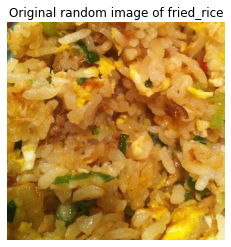

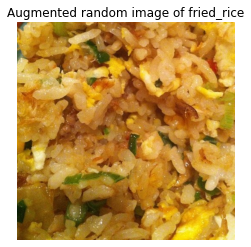

In [23]:
# Viewing random image and comparing it with its augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, random

# Selecting image file
target_class = random.choice(train_data_1percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Visualising selected file
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image of {target_class}")
plt.axis(False)

# Visualising augmented image
augmented_img = data_augmentation(img / 255.)
plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image of {target_class}")
plt.axis(False)

In [24]:
# Creating a model
input_shape = IMG_SIZE + (3,)
print(input_shape)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating input layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Adding augmentation layer
x = data_augmentation(inputs)

# Giving base model an augmented input
x = base_model(x, training=False)

# Pooling output features
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Putting Dense layer as an output
outputs = tf.keras.layers.Dense(
    10,
    activation="softmax",
    name="output_layer"
)(x)

# Making a model
model_1 = tf.keras.Model(inputs, outputs)

(224, 224, 3)


In [25]:
# Compiling the model
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
history_1 = model_1.fit(
    train_data_1percent,
    epochs=5,
    steps_per_epoch=len(train_data_1percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_aug")]
)

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221218-192158
Epoch 1/5
3/3 [==============================] - 90s 27s/step - loss: 2.4157 - accuracy: 0.1000 - val_loss: 2.2398 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 51s 24s/step - loss: 2.1304 - accuracy: 0.1857 - val_loss: 2.1259 - val_accuracy: 0.2615
Epoch 3/5
3/3 [==============================] - 51s 24s/step - loss: 1.9430 - accuracy: 0.4143 - val_loss: 2.0067 - val_accuracy: 0.3586
Epoch 4/5
3/3 [==============================] - 52s 24s/step - loss: 1.7663 - accuracy: 0.5143 - val_loss: 1.9093 - val_accuracy: 0.4112
Epoch 5/5
3/3 [==============================] - 50s 24s/step - loss: 1.5534 - accuracy: 0.7000 - val_loss: 1.8099 - val_accuracy: 0.4589


In [26]:
# Model details
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (512, 512, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
# Evaluating model on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 190s 2s/step - loss: 1.8136 - accuracy: 0.4496


[1.813556432723999, 0.4496000111103058]

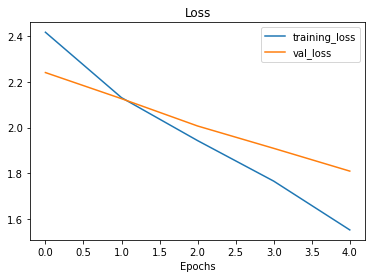

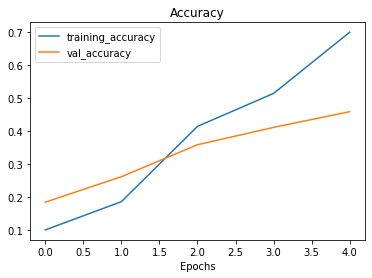

In [28]:
# Visualising loss curves
plot_loss_curves(history=history_1)

### Model 2

In [29]:
# Creating training and test dirs
train_dir_10percent = "10_food_classes_10_percent/train/"
test_dir_10percent = "10_food_classes_10_percent/test/"

In [30]:
# Setting up data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE=32

train_data_10percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data_10percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# Creating data augmentation layer
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    #tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name="augmentation_layer")

# Setting input shape
input_shape = (224, 224, 3)

# Creating a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating inputs and outputs
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = tf.keras.layers.Dense(
    10,
    activation="softmax",
    name="output_layer"
)(x)
model_2 = tf.keras.Model(inputs, outputs)

In [32]:
# Checking model layers
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [33]:
# Compiling the model
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [40]:
# Creating a ModelCheckpoint callback with model weights only
checkpoint_path = "./model_10percent_weights/"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq="epoch", # Saving checkpoint for every epoch
    verbose=1
)

In [35]:
# Fitting the model
initial_epochs = 5

history_2 = model_2.fit(
    train_data_10percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10percent),
    validation_data=test_data_10percent,
    validation_steps=int(0.25 * len(test_data_10percent)),
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="10_percent_data_aug"
        ),
        checkpoint_callback
    ]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221218-193016
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9278 - accuracy: 0.3867
Epoch 1: saving model to model_10percent_weights\
24/24 [==============================] - 143s 5s/step - loss: 1.9278 - accuracy: 0.3867 - val_loss: 1.4034 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2608 - accuracy: 0.7160
Epoch 2: saving model to model_10percent_weights\
24/24 [==============================] - 63s 3s/step - loss: 1.2608 - accuracy: 0.7160 - val_loss: 0.9875 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9665 - accuracy: 0.7760
Epoch 3: saving model to model_10percent_weights\
24/24 [==============================] - 93s 4s/step - loss: 0.9665 - accuracy: 0.7760 - val_loss: 0.7951 - val_accuracy: 0.8026
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.7973
Epo

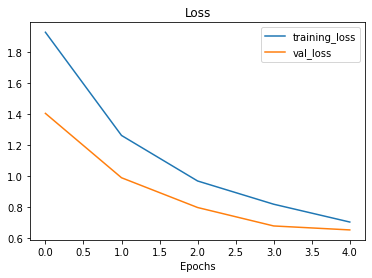

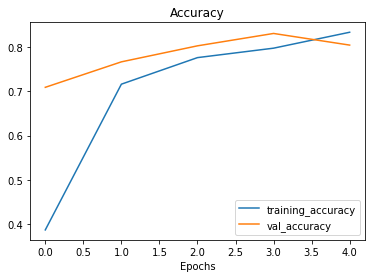

In [36]:
# Visualising loss curves
plot_loss_curves(history_2)

### Model 2 (Fine-tuned)

In [37]:
# Evaluating the original model
original_model2_results = model_2.evaluate(test_data_10percent)

79/79 [==============================] - 176s 2s/step - loss: 0.6194 - accuracy: 0.8348


In [42]:
# Loading in checkpointed weights
model_2.load_weights(checkpoint_path)

In [43]:
# Evaluating model with loaded weights
loaded_model2_results = model_2.evaluate(test_data_10percent)

79/79 [==============================] - 99s 1s/step - loss: 0.6194 - accuracy: 0.8348


In [44]:
# Checking if model outcomes are close enough
import numpy as np

np.isclose(np.array(original_model2_results), np.array(loaded_model2_results))

array([ True,  True])

In [45]:
# Checking the model outcome differences
print(np.array(original_model2_results) - np.array(loaded_model2_results))

[1.1920929e-07 0.0000000e+00]


In [46]:
# Checking model's layers
model_2.layers

In [47]:
# Checking if layers are trainable
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000028B8733D220> True
<keras.engine.sequential.Sequential object at 0x0000028B9348BAC0> True
<keras.engine.functional.Functional object at 0x0000028B9A77DF40> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000028B93473550> True
<keras.layers.core.dense.Dense object at 0x0000028B967D74F0> True


In [48]:
# Digging further into the base model
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [49]:
# How many trainable variables are in the base model
print(len(model_2.layers[2].trainable_variables))

0


In [50]:
# Setting last 10 layers of the base model as trainable
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompiling the model after the change
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine tuning, changing LR by 10x
    metrics=["accuracy"]
)

In [51]:
# Checking which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [52]:
# Chec the number of trainable variables
print(len(model_2.layers[2].trainable_variables))
print(len(model_2.trainable_variables))

10
12


In [53]:
# Fine tuning for another set of 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refitting the model
history_2_finetuned = model_2.fit(
    train_data_10percent,
    epochs = fine_tune_epochs,
    steps_per_epoch=len(train_data_10percent),
    validation_data=test_data_10percent,
    validation_steps=int(0.25 * len(test_data_10percent)),
    initial_epoch=history_2.epoch[-1], # Starting from previous last epoch
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="10_percent_finetuned"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/10_percent_finetuned/20221218-194728
Epoch 5/10
24/24 [==============================] - 81s 3s/step - loss: 0.6238 - accuracy: 0.8133 - val_loss: 0.5222 - val_accuracy: 0.8257
Epoch 6/10
24/24 [==============================] - 57s 2s/step - loss: 0.4957 - accuracy: 0.8587 - val_loss: 0.4997 - val_accuracy: 0.8306
Epoch 7/10
24/24 [==============================] - 88s 4s/step - loss: 0.4344 - accuracy: 0.8653 - val_loss: 0.5018 - val_accuracy: 0.8257
Epoch 8/10
24/24 [==============================] - 105s 4s/step - loss: 0.4094 - accuracy: 0.8827 - val_loss: 0.5284 - val_accuracy: 0.8191
Epoch 9/10
24/24 [==============================] - 108s 5s/step - loss: 0.3373 - accuracy: 0.8987 - val_loss: 0.4563 - val_accuracy: 0.8421
Epoch 10/10
24/24 [==============================] - 85s 4s/step - loss: 0.3037 - accuracy: 0.9133 - val_loss: 0.4577 - val_accuracy: 0.8454


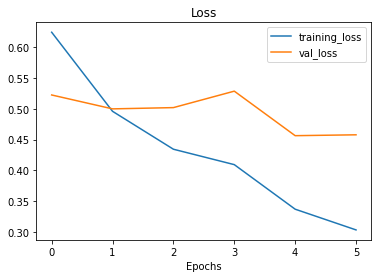

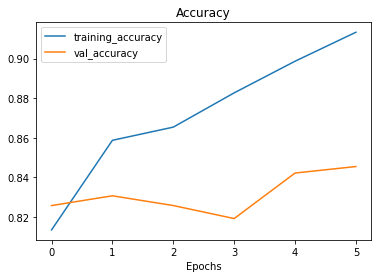

In [54]:
# Visualising the loss curves
plot_loss_curves(history_2_finetuned)

In [55]:
# Creating a function to compare histories
def compare_histories(original_history, new_history, initial_epochs):
    """
    Comparing two TF History objects
    """
    # Original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combined history measurements
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Making plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Finetuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Making plots for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Finetuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")    

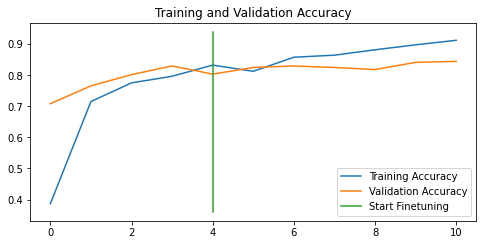

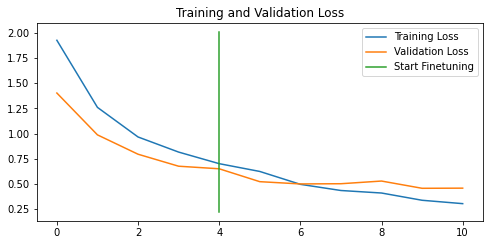

In [56]:
# Visualising our comparison
compare_histories(
    history_2,
    history_2_finetuned,
    initial_epochs=5
)

### Model 3

In [61]:
# Defining train and test directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir_all_data = "10_food_classes_all_data/test/"

In [62]:
# How many images we are working with
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [63]:
# Setting up data inputs
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data_10_classed_full = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_all_data,
    label_mode="categorical",
    image_size=IMG_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
